# Classification hierarchy with a minimum set of neurons

In my previous story, I examined the question of how many layers a neural network needs for simple classification tasks. I have explored the linear classification of the AND and OR data sets and the more complex XOR and two-moon data.

Using Keras, I showed that we need one layer to classify linear data, primarily as one hyperplane is sufficient to distinguish the different labels, while for more complex data we need at least two layers. Indeed, according to the universal approximation theorem (Cybenko, 1989: Approximation by Superpositions of a Sigmoidal Function), a two-layer neural network is enough to represent any function, but three (or more) layers allow us for greater flexibility in constructing logic combinations.

In this post, I would like to concentrate on the number of neurons per layer. The question I pose is how many neurons are needed for the classification task? To better understand the problem I construct a hierarchy of data sets, with various dimensions and focus on the minimum number of neurons per layer that are needed to distinguish the labels.

I will start by creating two 3-d spheres, one contains the other, and the aim is to distinguish between the two. After examining the 3-d problem, I will project the 3-d data on the 2-d plane and 1-d line and will explore the relationship between the neuron number per layer and the dimensionality of the data.

In [1]:
# load Keras, numpy, matplotlib and sklearn
from keras import models
from keras import layers

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.utils import check_random_state
from sklearn.decomposition import PCA

generator = check_random_state(42)
np.random.seed(42)

/Users/nc374/anaconda/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# define a few functions to generate the data and for ploting
def make_two_3d_circles(n_samples=10, r_out=1, r_in=0.7, noise=0.05):
    
    fig = plt.figure(figsize=(20,10))
    ax  = fig.add_subplot(111, projection='3d')

    # generate data
    u_out = np.random.uniform(0, 2 * np.pi, n_samples) 
    v_out = np.random.uniform(0, 2 * np.pi, n_samples)
    u_in  = np.random.uniform(0, 2 * np.pi, n_samples) 
    v_in  = np.random.uniform(0, 2 * np.pi, n_samples)
    
    x_out = r_out * np.outer(np.cos(u_out), np.sin(v_out)) + generator.normal(scale=noise, size=(n_samples,n_samples))
    y_out = r_out * np.outer(np.sin(u_out), np.sin(v_out)) + generator.normal(scale=noise, size=(n_samples,n_samples))
    z_out = r_out * np.outer(np.ones(np.size(u_out)), np.cos(v_out)) + generator.normal(scale=noise, size=(n_samples,n_samples))
    x_in  = r_in  * np.outer(np.cos(u_in), np.sin(v_in)) + generator.normal(scale=noise, size=(n_samples,n_samples))
    y_in  = r_in  * np.outer(np.sin(u_in), np.sin(v_in)) + generator.normal(scale=noise, size=(n_samples,n_samples))
    z_in  = r_in  * np.outer(np.ones(np.size(u_in)), np.cos(v_in)) + generator.normal(scale=noise, size=(n_samples,n_samples))

    # Plot the surface
    ax.scatter(x_in,  y_in,  z_in,  alpha=0.4 , color='b', s=200)
    ax.scatter(x_out, y_out, z_out, alpha=0.4 , color='r' , s=200)

    for t in ax.xaxis.get_major_ticks(): t.label.set_fontsize(20)
    for t in ax.yaxis.get_major_ticks(): t.label.set_fontsize(20)
    for t in ax.zaxis.get_major_ticks(): t.label.set_fontsize(20)

    ax.set_xlabel('\n\ndistance from the origin', fontsize=20)
    ax.set_ylabel('\n\ndistance from the origin', fontsize=20)
    ax.set_zlabel('\n\ndistance from the origin', fontsize=20)
    plt.show()

    X = np.vstack((np.append(x_out, x_in),
                   np.append(y_out, y_in),
                   np.append(z_out, z_in))).T
    y = np.hstack([np.zeros(int(len(X)/2), dtype=np.intp),
                   np.ones (int(len(X)/2), dtype=np.intp)])
    return(X,y)

def plot_data_2d(X, y, title_str):
    
    amin, bmin = X.min(axis=0) - 0.1
    amax, bmax = X.max(axis=0) + 0.1
    hticks = np.linspace(amin, amax, 101)
    vticks = np.linspace(bmin, bmax, 101)
    
    plt.figure(figsize=(20,10))
    plt.scatter(X[y==0,0], X[y==0,1],c='r', s=200, alpha=0.4)
    plt.scatter(X[y==1,0], X[y==1,1],c='b', s=200, alpha=0.4)
    plt.title(title_str,fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlim(amin, amax)
    plt.ylim(bmin, bmax)
    plt.grid('on')

def plot_data_1d(X, y, title_str):

    plt.plot(X[y==1],'ob', markersize=12, alpha=0.4)
    plt.plot(X[y==0],'or', markersize=12, alpha=0.4)
    plt.title(title_str,fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.grid('on')

def plot_data_1d_2nd_look(X, y, title_str):
    
    plt.plot(X[y==1],np.ones(X[y==1].shape),'ob', markersize=12, alpha=0.1)
    plt.plot(X[y==0],np.zeros(X[y==0].shape),'or', markersize=12, alpha=0.1)
    plt.title(title_str,fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.grid('on')

    
def plot_loss_acc(loss_values, acc_values, titles, legends):
    
    plt.subplot(121)
    epochs = range(1, len(loss_values) + 1)
    plt.plot(epochs, loss_values, 'o', label=titles[0])
    plt.title(titles[0],fontsize=20)
    plt.xlabel('Epoch',fontsize=20)
    plt.ylabel('Loss',fontsize=20)
    plt.legend(legends,fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    plt.subplot(122)
    epochs = range(1, len(acc_values) + 1)
    plt.plot(epochs, acc_values, 'o', label=titles[1])
    plt.title(titles[1],fontsize=20)
    plt.xlabel('Epoch',fontsize=20)
    plt.ylabel('Accuracy',fontsize=20)
    plt.legend(legends,fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

# The 3-d data

Here is a figure showing the data. The inside sphere (blue dots) is labeled as zero, while the outer sphere (red dots) is labeled as one. The objective is to distinguish between the two using a neural-network model with a minimum number of neurons and layers.

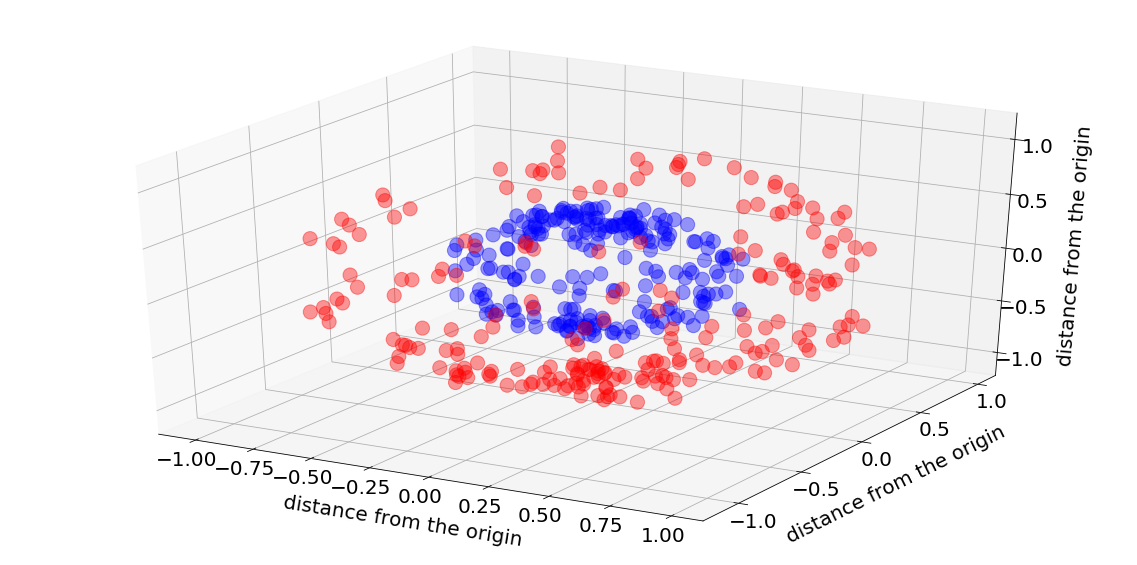

In [3]:
X_3d, y_3d = make_two_3d_circles(n_samples=15, r_out=1, r_in=0.5, noise=0.05)

In [4]:
print(X_3d.shape)
print(y_3d.shape)

(450, 3)
(450,)


As I explained earlier, and as one can see, one hyperplane cannot separate the two spheres, and we must use a nonlinear model. The minimum number of layers is two, but how many neurons do we need in each?

The excellent online book by Michael Nielsen interactively explores what can neurons compute (Chapter 4), and the relevant bottom line is that one neuron can learn a step function, while a pair of neurons can represent a bump function.

Step and bump functions are essential for classification, as they can distinguish an area or region. So, a pair of neurons can isolate connected 1-d data, as the XOR data in my last post, mainly by learning the best two straight lines (or hyperplanes) that are needed to distinguish the data. For 2-d data, at least four hyperplanes are required, while for 3-d data at least six hyperplanes are needed. Let me explain why this is the case.
Let us start by thinking about the 3-d problem. Our data have two balls, one inside the other, and we try to isolate one from the other. Imagine that you take an imaginary shoe-box and place the inner ball inside it. This is an excellent way to separate the inner ball from the outer one, isn’t it?

How many sides (or hyperplanes) does the shoe box have? 

Six! 

So, for the 3-d classification problem, at least six hyperplanes are needed to classify or isolate a connected convex data such as a 3-d ball or a sphere. Other words, a bump function in each of the three directions allows us to represent a closed area within the 3-d domain.

To conclude, this simple, intuitive discussion led us to the deduce that the minimum network that can classify the inner ball is a two-layer network with six and one neurons.

In [5]:
#training constants
epochs_num=500
batch_size_num=32
verbose_num=0

In [6]:
model = models.Sequential()
model.add(layers.Dense(2, activation='relu', input_shape=(3,)))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history_2_1 = model.fit(X_3d, y_3d, epochs=epochs_num, 
                        batch_size=batch_size_num, verbose=verbose_num).history

model = models.Sequential()
model.add(layers.Dense(4, activation='relu', input_shape=(3,)))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history_4_1 = model.fit(X_3d, y_3d, epochs=epochs_num, 
                        batch_size=batch_size_num, verbose=verbose_num).history

model = models.Sequential()
model.add(layers.Dense(6, activation='relu', input_shape=(3,)))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history_6_1 = model.fit(X_3d, y_3d, epochs=epochs_num, 
                        batch_size=batch_size_num, verbose=verbose_num).history

As expected, we can see that the two-layer neural network with the six and one neurons (denoted 6_1) learns to classify the data correctly after about 400 iterations while the four-one (denoted 4_1) and two-one (denoted 2_1) networks don’t have enough nonlinear flexibility to isolate the inner ball.

/Users/nc374/anaconda/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


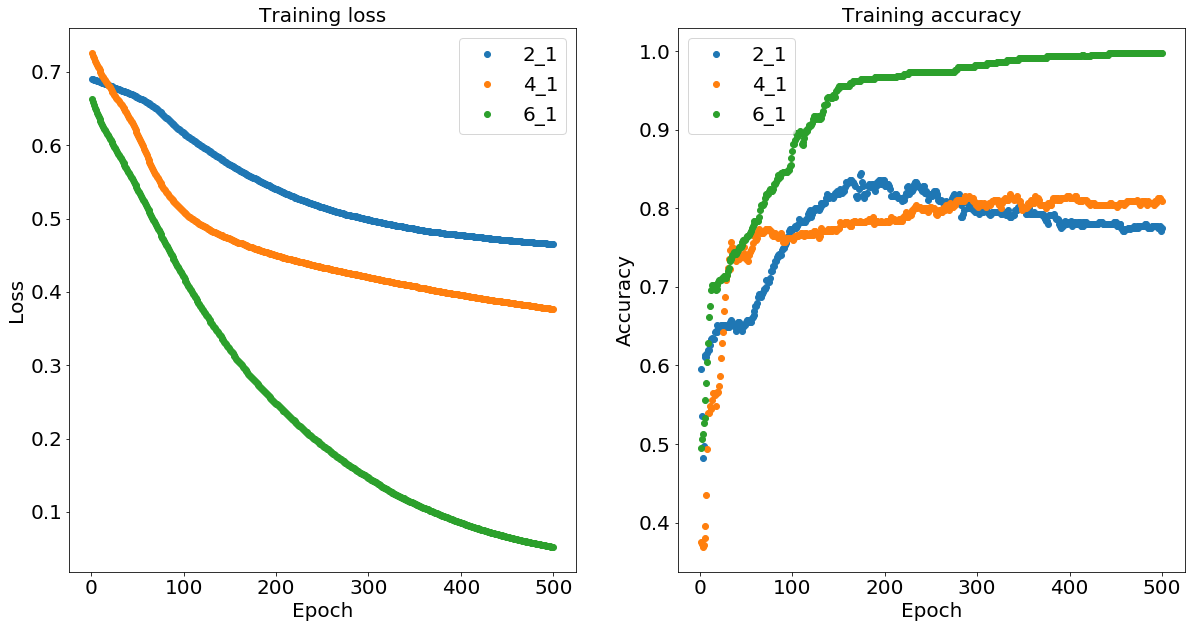

In [7]:
plt.figure(figsize=(20,10))
plot_loss_acc(history_2_1['loss'], history_2_1['acc'],
              ['Training loss','Training accuracy'],['2_1','4_1','6_1'])
plot_loss_acc(history_4_1['loss'], history_4_1['acc'],
              ['Training loss','Training accuracy'],['2_1','4_1','6_1'])
plot_loss_acc(history_6_1['loss'], history_6_1['acc'],
              ['Training loss','Training accuracy'],['2_1','4_1','6_1'])
plt.show()

# The 2-d data

Next, I want to use Keras again, and examine the 2-d problem. Instead of slicing the previous 3-d balls, I will project the 3-d balls on the 2-plane utilizing the PCA dimensional reduction technique, essentially projecting the data onto the two directions containing the most significant variability of the data (radius and angle).

In [8]:
X_2d = PCA(n_components=2).fit_transform(X_3d)

y_2d = np.hstack([np.zeros(int(len(X_2d)/2), dtype=np.intp),
                  np.ones (int(len(X_2d)/2), dtype=np.intp)])

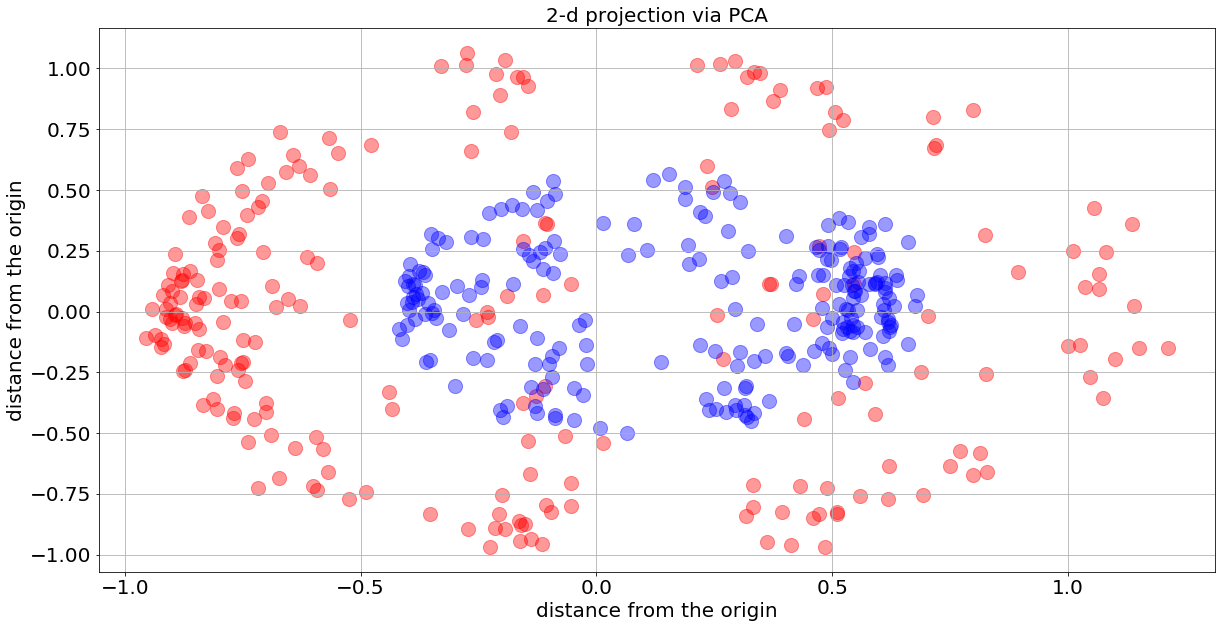

In [9]:
plot_data_2d(X_2d, y_2d,'2-d projection via PCA')
plt.ylabel('distance from the origin',fontsize=20)
plt.xlabel('distance from the origin',fontsize=20)
plt.show()

One can see that the inner 2-d ball contains mostly blue dots, while the outer 2-d ball contains entirely red dots — this is a consequence of the PCA projection.

How many layer and neurons are needed to distinguish the two labels? The logic of the previous section stands, and this should lead you to conclude that two-layer network with four and one neurons is the minimum required to classify the data. Let us see whether this is the case.

In [10]:
model = models.Sequential()
model.add(layers.Dense(2, activation='relu', input_shape=(2,)))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history_2_1 = model.fit(X_2d, y_2d, epochs=epochs_num, 
                        batch_size=batch_size_num, verbose=verbose_num).history

model = models.Sequential()
model.add(layers.Dense(4, activation='relu', input_shape=(2,)))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history_4_1 = model.fit(X_2d, y_2d, epochs=epochs_num, 
                        batch_size=batch_size_num, verbose=verbose_num).history

As expected, we can see that the two-layer neural network with the four and one neurons (denoted 4_1) learns to classify the data correctly after about 400 iterations while the two-one network (denoted 2_1) doesn’t have enough nonlinear flexibility to isolate the inner 2-d ball.

/Users/nc374/anaconda/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


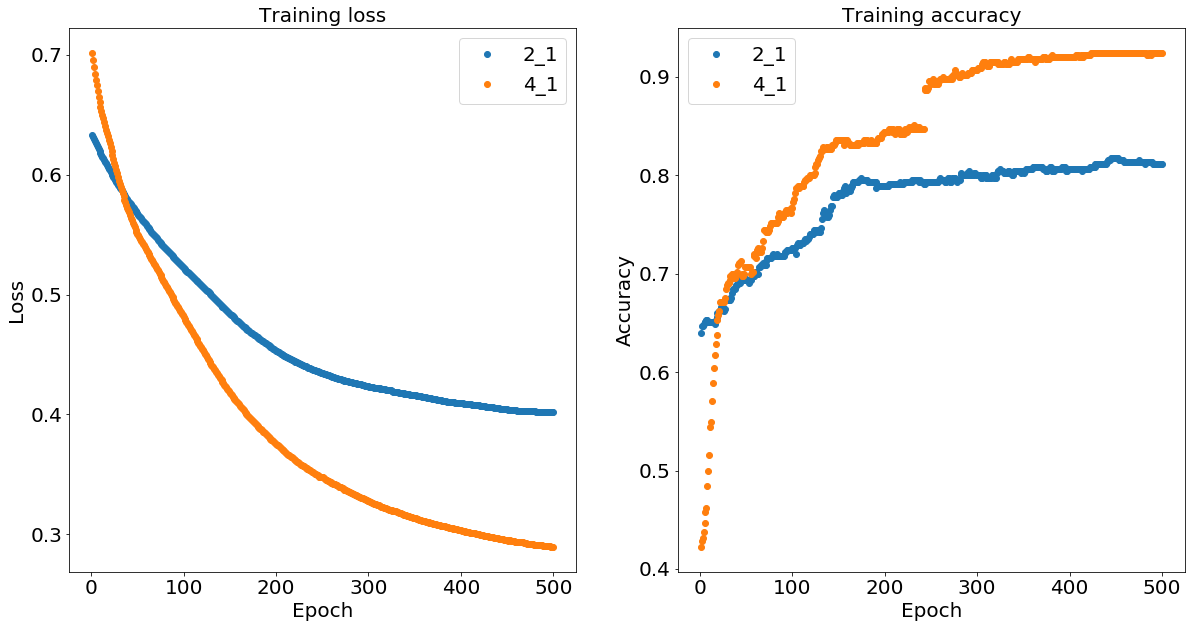

In [11]:
plt.figure(figsize=(20,10))
plot_loss_acc(history_2_1['loss'], history_2_1['acc'],
              ['Training loss','Training accuracy'],['2_1','4_1'])
plot_loss_acc(history_4_1['loss'], history_4_1['acc'],
              ['Training loss','Training accuracy'],['2_1','4_1'])
plt.show()

# The 1-d data

Lastly, I will project the 3-d ball onto the 1-d line and try to isolate the labels. I will repeat my previous methodology, projecting the 3-d data using the PCA technique. 

In the following figure, I show how the 1-d data look like in two different ways — the bottom line is that the data comes out less clean and less separable. So, we don’t expect the network to classify the data with 100% accuracy but still, expect to see the loss function decreasing monotonically with the number of iterations.

In [12]:
X_1d = PCA(n_components=1).fit_transform(X_3d)
y_1d = np.hstack([np.zeros(int(len(X_1d)/2), dtype=np.intp),
                  np.ones (int(len(X_1d)/2), dtype=np.intp)])

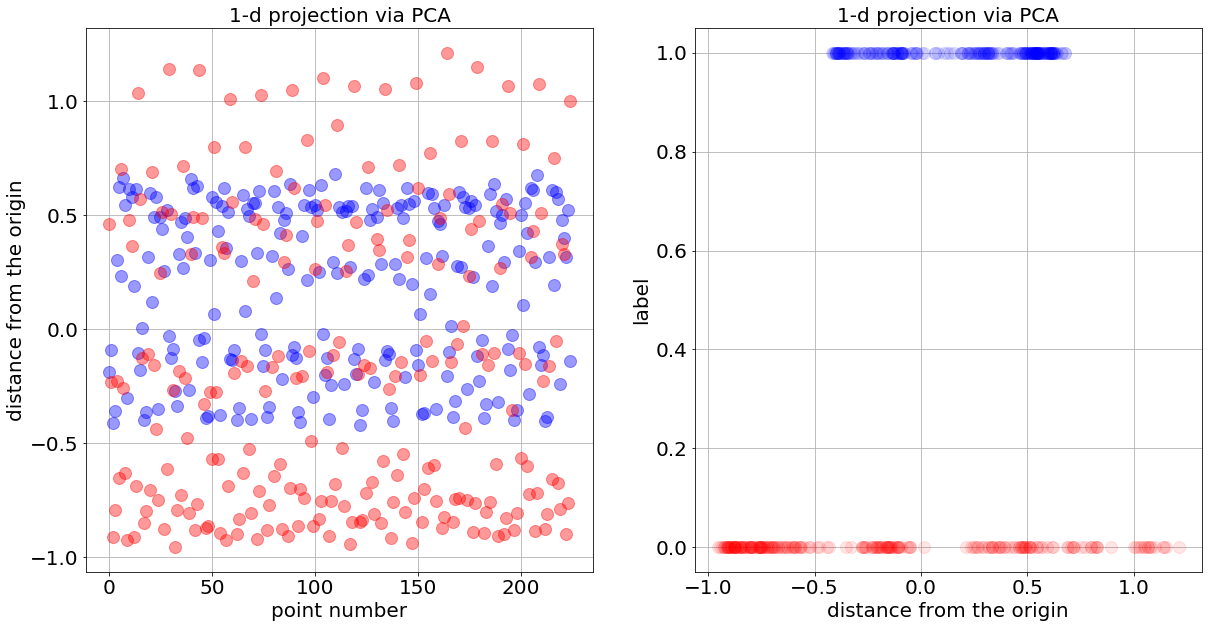

In [13]:
plt.figure(figsize=(20,10))
plt.subplot(121)
plot_data_1d(X_1d, y_1d,'1-d projection via PCA')
plt.ylabel('distance from the origin',fontsize=20)
plt.xlabel('point number',fontsize=20)

plt.subplot(122)
plot_data_1d_2nd_look(X_1d, y_1d,'1-d projection via PCA')
plt.ylabel('label',fontsize=20)
plt.xlabel('distance from the origin',fontsize=20)
plt.show()

How many layer and neurons are needed to distinguish the two 1-d balls? The previous logic stands, and this should lead you to conclude that two-layer network with two and one neurons (denoted 2_1) is the minimum required to classify the data.

In [14]:
epochs_num=800
model = models.Sequential()
model.add(layers.Dense(2, activation='relu', input_shape=(1,)))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history_2_1 = model.fit(X_1d, y_1d, epochs=epochs_num, 
                        batch_size=batch_size_num, verbose=verbose_num).history

As explained and as expected, the longer we train the data, the lower the loss function gets and the higher the prediction accuracy becomes.

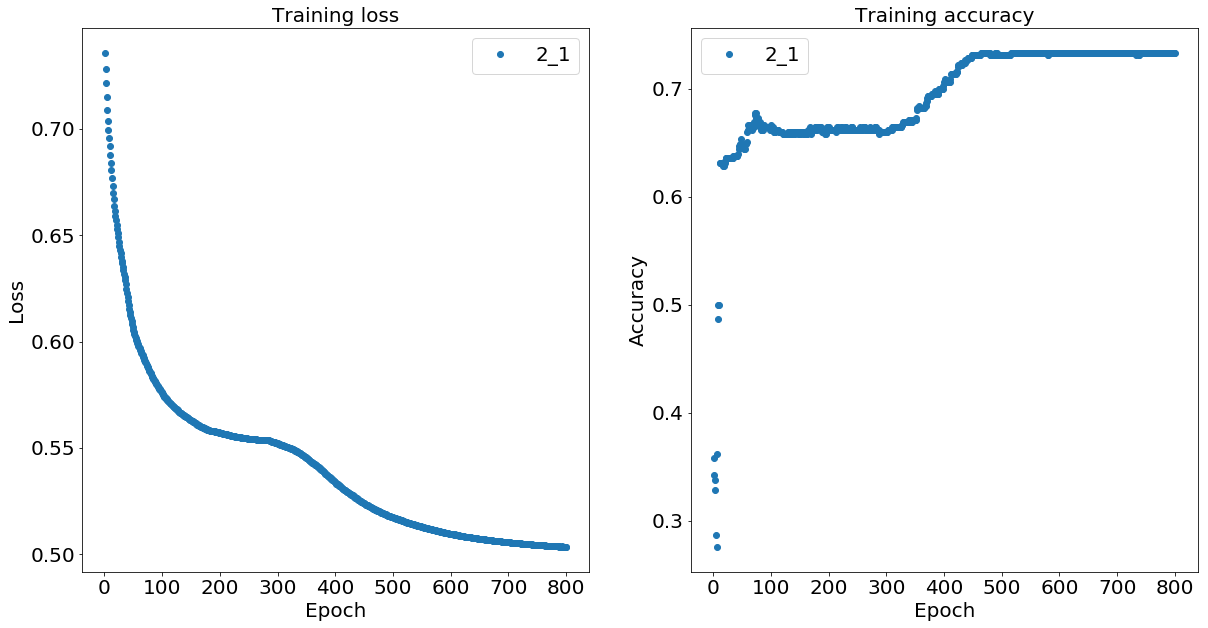

In [15]:
plt.figure(figsize=(20,10))
plot_loss_acc(history_2_1['loss'], history_2_1['acc'],
              ['Training loss','Training accuracy'],['2_1','4_1','6_1'])
plt.show()

# Conclusion

To conclude the post, I explored the classification hierarchy of two-balls, one inside the other, in various dimensions. I showed that for this convex problem, a two-layer network is enough to classify the data correctly and that the minimum number of neurons is 2N and 1, where N stands for the dimension of the balls.